# Stable Diffusion Upscaling

Importing relevant packages for querying endpoint and image visualization

In [ ]:
# import matplotlib.pyplot as plt
# from IPython.core.display import HTML
# import numpy as np
# import json
# from io import BytesIO

In [ ]:
!pip install -U 'stability-sdk[sagemaker] @ git+https://github.com/Stability-AI/stability-sdk.git@sagemaker'
!pip install protobuf==3.20

In [3]:
import sagemaker
from sagemaker import ModelPackage, get_execution_role
from stability_sdk_sagemaker.predictor import StabilityPredictor
from stability_sdk_sagemaker.models import get_model_package_arn
from stability_sdk.api import GenerationRequest, GenerationResponse, TextPrompt

import matplotlib.pyplot as plt
from IPython.core.display import HTML
import numpy as np
import json
from io import BytesIO

from PIL import Image
from typing import Union, Tuple
import io
import os
import base64
import boto3

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
model_package_map = {
    "us-east-1": "arn:aws:sagemaker:us-east-1:865070037744:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-east-2": "arn:aws:sagemaker:us-east-2:057799348421:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "us-west-2": "arn:aws:sagemaker:us-west-2:594846645681:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ca-central-1": "arn:aws:sagemaker:ca-central-1:470592106596:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-central-1": "arn:aws:sagemaker:eu-central-1:446921602837:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-1": "arn:aws:sagemaker:eu-west-1:985815980388:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "eu-west-2": "arn:aws:sagemaker:eu-west-2:856760150666:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-2": "arn:aws:sagemaker:ap-northeast-2:745090734665:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-northeast-1": "arn:aws:sagemaker:ap-northeast-1:977537786026:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad",
    "ap-south-1": "arn:aws:sagemaker:ap-south-1:077584701553:model-package/sdxl-v1-0-8cc703e-43ceeb816ad635d18270e159eb5096ad"
}


region = boto3.Session().region_name
if region not in model_package_map.keys():
    raise ("UNSUPPORTED REGION")
package_arn = model_package_map[region]  # TODO

role_arn = get_execution_role()
sagemaker_session = sagemaker.Session()

# Generate low-resolution image

## Create image of green iguana

In [ ]:
# # Choose your endpoint name
# from sagemaker.utils import name_from_base
# endpoint_name=name_from_base('sdxl-1-0-jumpstart') # change this as desired

In [5]:
# Set your SDXL endpoint name
endpoint_name="sdxl-1-0-intro-2023-09-10-18-23-56-477"

In [6]:
deployed_model = StabilityPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)

In [7]:
prompt = "Create an image of a green iguana in the Amazon rainforest"

In [9]:
image_path="generated-images"

In [10]:
image_name = "{}.png".format(prompt.replace(" ", "_"))
image_name

'Create_an_image_of_a_green_iguana_in_the_Amazon_rainforest.png'

In [11]:
output = deployed_model.predict(
    GenerationRequest(text_prompts=[TextPrompt(text=prompt)],
                      style_preset="photographic",
                      seed = 42,
                      width=512,
                      height=512
                     )
)

In [12]:
def decode_and_show(model_response: GenerationResponse, image_name) -> None:
    """
    Decodes and displays an image from SDXL output

    Args:
        model_response (GenerationResponse): The response object from the deployed SDXL model.

    Returns:
        None
    """
    image = model_response.artifacts[0].base64
    image_data = base64.b64decode(image.encode())
    image = Image.open(io.BytesIO(image_data))
    image.save(image_path+"/"+image_name)
    display(image)

## Show generated (high-res) image

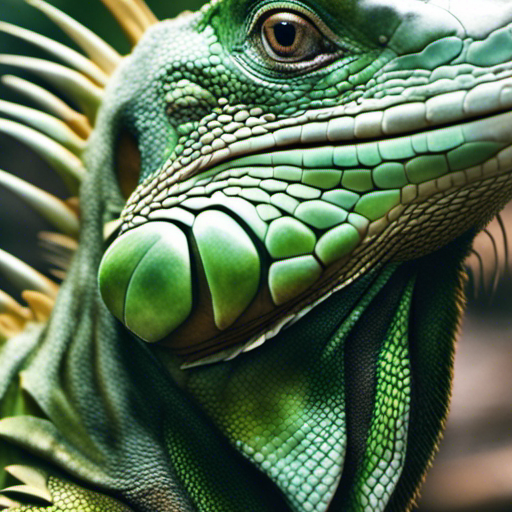

In [39]:
decode_and_show(output, image_name_1)

## Manually convert this image intp low-res quality: 128x128px, 10% quality JPG

In [30]:
low_res_img_file_name = "img/green_iguana_lowres.jpg"

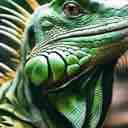

In [31]:
display(Image.open(low_res_img_file_name))

# Upscaling Image with Stable Diffusion x4 upscaler FP16

In [32]:
endpoint_name = 'jumpstart-dft-stable-diffusion-x4-upscaler-fp16'

### Query endpoint

In [33]:
with open(low_res_img_file_name,'rb') as f: low_res_image_bytes = f.read()
encoded_image = base64.b64encode(bytearray(low_res_image_bytes)).decode()

payload = { "prompt":"a green iguana", "image": encoded_image,  "num_inference_steps":50, "guidance_scale":7.5}


In [34]:
def query_endpoint(payload):
    """query the endpoint with the json payload encoded in utf-8 format."""
    
    client = boto3.client('runtime.sagemaker')
    # Accept = 'application/json;jpeg' returns the jpeg image as bytes encoded by base64.b64 encoding.
    # To receive raw image with rgb value set Accept = 'application/json'
    # To send raw image, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open('low_res_image.jpg')).tolist()
    # Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json;jpeg', Accept = 'application/json;jpeg', Body=payload)
    return response

def parse_response(query_response):
    """Parse the endpoint response and returns the generated image and the original prompt"""
    
    response_dict = json.loads(query_response['Body'].read())
    return response_dict['generated_images'], response_dict['prompt']

In [35]:
query_response = query_endpoint(json.dumps(payload).encode('utf-8'))

In [36]:
generated_images, prompt = parse_response(query_response)

Next, we display the generated image

In [42]:
# def display_image(img, title):
#     plt.figure(figsize=(12,12))
#     plt.imshow(np.array(img))
#     plt.axis('off')
#     plt.title(title)
#     plt.show()

In [43]:
# def display_save_image(img, title):
# #    image = model_response.artifacts[0].base64
# #    image_data = base64.b64decode(image.encode())
#     image = Image.open(io.BytesIO(img))
#     image.save("generated-images/green_iguana_upscaled.png")
#     display(image)

## Show low-res image

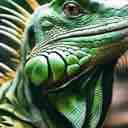

In [37]:
display(Image.open("img/green_iguana_lowres.jpg"))

In [38]:
HTML('<table><tr><td> <img src="img/green_iguana_lowres.jpg" alt="iguana" style="height: 512px;"/> <figcaption>original low resolution image</figcaption>'
     '</td></tr></table>')

original low resolution image


## Show upscaled image

In [39]:
image_name = "generated-images/green_iguana_upscaled.png"

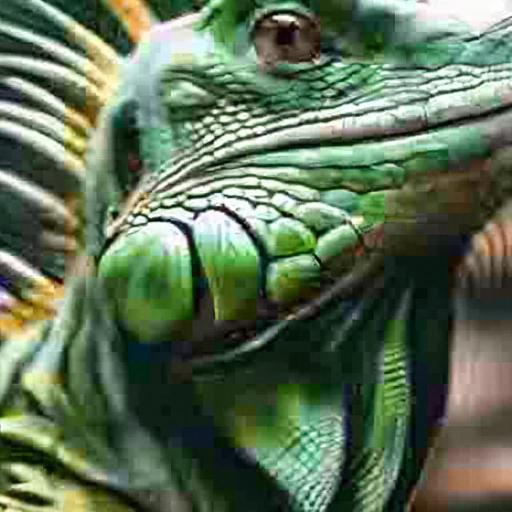

In [40]:
for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
    generated_image_rgb.save(image_name)
    display(generated_image_rgb)

In [46]:
# for generated_image in generated_images:
#     generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
#     generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
#     display_image(generated_image_rgb, "upscaled image generated by model")

### Supported parameters

***
This model supports many parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.
* **noise_level**: add noise to latent vectors before upscaling. If specified, it must be an integer.

***

# Delete an endpoint

When you've finished working, you can delete the endpoint to release the EC2 instance(s) associated with it, and stop billing.

Get your list of Sagemaker endpoints using the AWS Sagemaker CLI like this:

In [ ]:
!aws sagemaker list-endpoints

In [ ]:
# deployed_model.sagemaker_session.delete_endpoint(endpoint_name)
# # Rerun the aws cli command above to confirm that its gone.